<center><h1>QBUS6840 - Predictive Analytics </h1></center>

# Tutorial 6 – Simple Exponential Smoothing
 
### Objectives:

- Implement the Simple Exponential Smoothing algorithm manually
- Learn how to use the `ewm()` method of `DataFrame` to quickly implement the Simple Exponential Smoothing algorithm.
- Performing grid search for the smoothing weight in Simple Exponential Smoothing
- Implement the Trend corrected exponential smoothing (TCES), i.e. Holt's linear method.

## 1. Simple Exponential Smoothing

Simple Exponential Smoothing (SES), also called exponential weighted smoothing (EWM), belongs to the class of Exponential Smoothing techniques, which can be used to smooth time series data or forecast unseen data. In this tutorial, we are interested in the component form of SES, which is defined as:

$$
\widehat{Y}_{t+1|1:t} = l_t = \alpha Y_t + (1-\alpha) l_{t-1} = \alpha Y_t + (1-\alpha) \widehat{Y}_t
\tag{1}
$$

where $ 0 \le \alpha \le 1$. Here, we first calculate the level $l_t$ and then use it as the forecast $\widehat{Y}_{t+1|1:t}$.

Continue the calculation steps:
$$
\begin{eqnarray}
\widehat{Y}_{t|1:t-1} &=& l_{t-1} &=& \alpha Y_{t-1} + (1-\alpha) l_{t-2} \\
\widehat{Y}_{t-1|1:t-2} &=& l_{t-2} &=& \alpha Y_{t-2} + (1-\alpha) l_{t-3} \\
\widehat{Y}_{t-2|1:t-3} &=& l_{t-3} &=& \alpha Y_{t-3} + (1-\alpha) l_{t-4} \\
... \\
\widehat{Y}_{4|1:3} &=& l_{3} &=& \alpha Y_{3} + (1-\alpha) l_{2} \\
\widehat{Y}_{3|1:2} &=& l_{2} &=& \alpha Y_{2} + (1-\alpha) l_{1} \\
\widehat{Y}_{2|1} &=& l_{1} &=& \alpha Y_{1} + (1-\alpha) l_{0} \\
\end{eqnarray}
\tag{2}
$$

Finally, we combine the above equations together, we will finally have:

$$\widehat{Y}_{t+1|1:t} = l_t = \alpha Y_t + \alpha (1-\alpha) Y_{t-1} + \alpha (1-\alpha)^2 Y_{t-2} + ... + \alpha (1-\alpha)^{t-1} Y_1 + (1-\alpha)^t l_0
\tag{3}
$$

You may notice in order to get $l_t$, which is the forecast $\widehat{Y}_{t+1|1:t}$, we need to define the value of $\alpha$ and $l_0$. The value of $\alpha$ is important to the SES algorithm, hence inappropriate value selection will result in inaccurate forecasting results. Or we can have $\alpha$ estimated as a parameter, see lecture 5 for details. Since when forecasting $\widehat{Y}_{t+1|1:t}$ the coefficent $(1-\alpha)^t$ of $l_0$ could be very small when $t$ is large (note $0\le\alpha\le 1$), the selection of $l_0$ could be a bit more "relaxed".

In this task, we will implement the SES method for the **"AustralianVisitors.csv"** dataset. Firstly, we will manually smooth the data by using a self-defined function implementing the SES algorithm, and then call `ewm()` method of Series objects to perform the same task. 

Finally, we will discuss how to select good values for $\alpha$ using the grid search stratergy. In this tutorial, we choose $l_0 = y_1$ for simplicity. You can also refer to the grid search steps of selecting $\alpha$ to select $l_0$ accordingly, or as in slides 16 and 19 of lecture 5 we can have $l_0$ estimated.

## 1.  Load AustralianVisitors data

Create a new Jupyter Notebook called "Tutorial_06.ipynb" and download the ***AustralianVisitors.csv*** file from Canvas. Let's begin our script by importing necessary libraries. We then load the dataset.

In [2]:
import warnings
warnings.filterwarnings("ignore")
# Import some external libraries
import pandas as pd                # For data manipulation
import matplotlib.pyplot as plt    # For visualization
import numpy as np                 # For linear algebra
from sklearn.linear_model import LinearRegression # For Linear Regression

# Then read the data file into a DataFrame object
data = pd.read_csv('AustralianVisitors.csv')
data['Month'] = pd.to_datetime(data['Month']) # Convert the data in the Month column to datetime
data.set_index('Month', inplace=True)         # Indexing the DataFrame by the Month column
data.head()  


,No of Visitors
Month,
1991-01-01,177400
1991-02-01,190600
1991-03-01,189200
1991-04-01,168000
1991-05-01,161400


 Plot the time series showing number of visitors to Australia during 1991-2016.

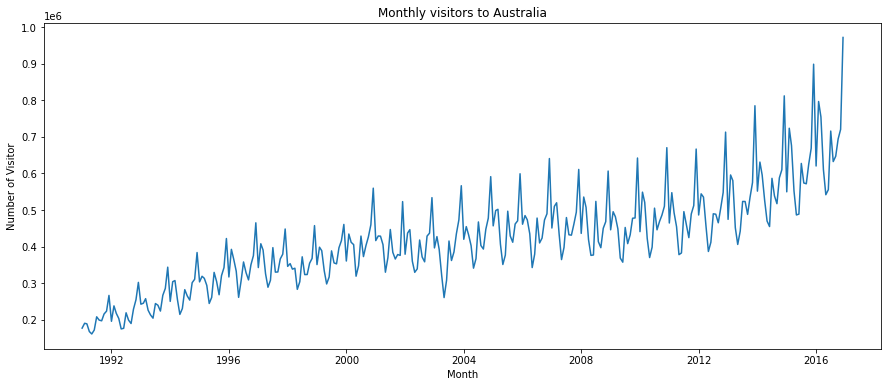

In [4]:
visitors = data['No of Visitors']

# Plot the time series
plt.figure(figsize=(15,6))
plt.plot(data.index,visitors)
plt.xlabel('Month')
plt.ylabel('Number of Visitor')
plt.title("Monthly visitors to Australia")
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- If we want to use the time series decomposition approach, which model should we use for the `visitors` series, **additive** or **multiplicative** models? Why?
- Assume that we have done the step 2 of the decomposition approach where we have obtained the seasonally adjusted series, what could be a good model for the final trend estimation? **Hint:** Should we use a linear line or a polynomial curve to capture the trend?  

## 2. Smooth the time series using SES

In this section, we will learn how to implement the SES method to smooth the `visitors` series manually and then replicate the results using a built-in method of Series object of Pandas. 

### 2.1. Implement SES manually

For the purpose of this section, we implement the SES method with pre-define smoothing weight $\alpha$ and initial level $l_0$. A common choice for the initial level is $l_0=Y_1$, e.g. using the first observed data point as the initial level. We will show later how to efficiently select good values for $\alpha$. The manual implementation logics follow mathematical steps in (2).   



次指数平滑又叫简单指数平滑（simple exponential smoothing， SES），适合用来预测没有明显趋势和季节性的时间序列。其预测结果是一条水平的直线。模型形如

In [48]:
# Set a small value for alpha 
alpha = 0.1
# alpha =1 如果是一的話就是用天真算法
# alpha 越大根實際值會越接近

#越久之前的對現在預測越來越不重要
# Initialize the smooth series by copying the visitors series(pre-allocation)
# By doing this, we imply that l0 is set to be the first value of the visitors series 
lt_manual = visitors.copy().astype(float)# change to float part

# Define l0 and compute l1
l0 = visitors[0]
lt_manual[0] = alpha*visitors[0] + (1-alpha)*l0
# 要那麼多小數點就是因為我們要很精準的答案


# Start from l1
for t in range(1,len(visitors)):
    # Calculate smoothed value at time t using equations in (2)
    lt_manual[t] = alpha*visitors[t] +(1-alpha)*lt_manual[t-1]
    
print(lt_manual)
# lt_manual

Month
1991-01-01    177400.000000
1991-02-01    178720.000000
1991-03-01    179768.000000
1991-04-01    178591.200000
1991-05-01    176872.080000
                  ...      
2016-08-01    636387.208920
2016-09-01    637468.488028
2016-10-01    643151.639225
2016-11-01    650886.475302
2016-12-01    682977.827772
Name: No of Visitors, Length: 312, dtype: float64


##### <div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What does `astype(float)` mean? What will happen if we don't add `astype(float)`?
- Manually compute $l_1$ and compare to the second value in the level series, are they similar?

It is useful to plot the manual smoothed curve (the level series) and the original time series

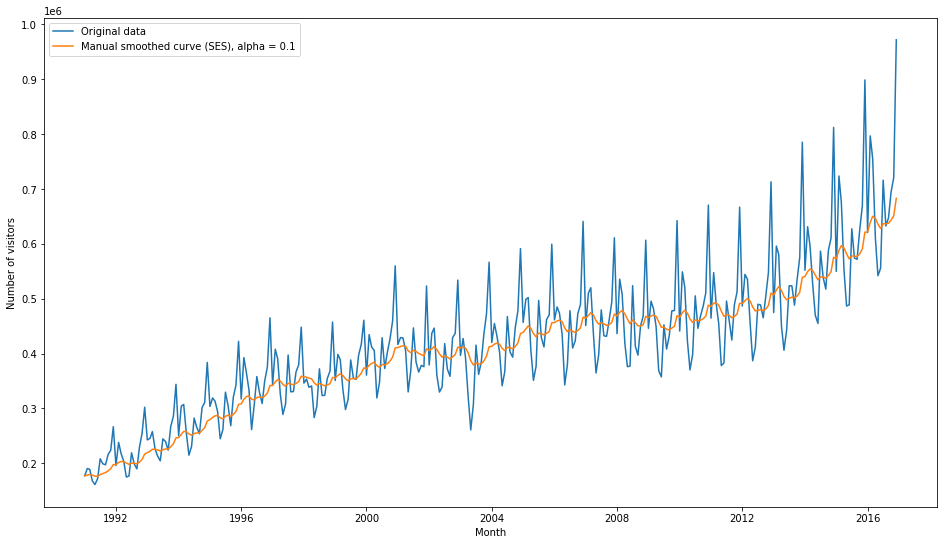

In [49]:
plt.figure(figsize=(16,9))
plt.plot(visitors, label = "Original data")
plt.plot(lt_manual, label = "Manual smoothed curve (SES), alpha = 0.1")
plt.xlabel('Month')
plt.ylabel('Number of visitors')
plt.legend()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Can you set $l_0 = \frac{(y_1+y_2+y_3)}{3}$ and redo the smoothing?
前幾個會不一樣之後都一樣了


- Could you see the effect of changing the initial level $l_0$? **Hint:** Visualize the smoothed series in two cases

ans, almost same result

### 2.2. Implement SES using Pandas

We can use the `ewm()` method of Series objects to implement the SES method automatically. Similar to the `rolling()` method, we need to call `mean()` on the output of `ewm()` method to exactly implement the SES algorithm in equations (2). We will use different values of $\alpha$ to see the effects of the smoothing weight on the smoothed values produced by the EWM smoothing technique.  

In [52]:
lt_pandas1 = visitors.ewm(alpha=0.05,adjust=False).mean()
lt_pandas2 = visitors.ewm(alpha=0.1, adjust=False).mean()
lt_pandas3 = visitors.ewm(alpha=0.3, adjust=False).mean()
lt_pandas4 = visitors.ewm(alpha=0.7, adjust=False).mean()
print(type(lt_pandas2))

<class 'pandas.core.series.Series'>


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What does `adjust=False` mean? What will you obtain if `adjust=True`?yes they are hvaing same result
- Compare `lt_pandas2` and `lt_manual` (with $\alpha=0.1$), are they similar?

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - ewm() </h3></div>



https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

Plot and compare the different values of alpha

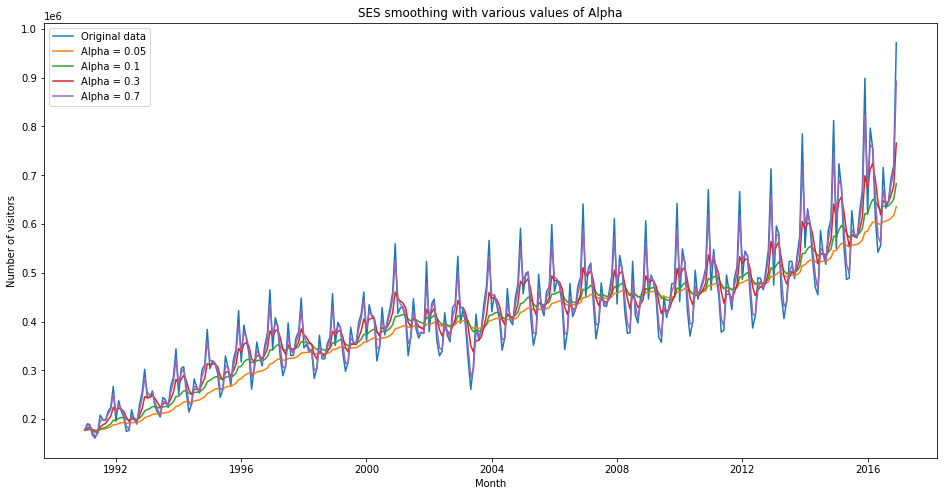

In [46]:
plt.figure(figsize=(16,8))
plt.plot(visitors, label='Original data')
plt.plot(lt_pandas1, label = "Alpha = 0.05")
plt.plot(lt_pandas2, label = "Alpha = 0.1")
plt.plot(lt_pandas3, label = "Alpha = 0.3")
plt.plot(lt_pandas4, label = "Alpha = 0.7")
plt.xlabel('Month')
plt.ylabel('Number of visitors')
plt.title("SES smoothing with various values of Alpha")
plt.legend()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What does the smoothed series look like when we increase or decrease the smoothing weight $\alpha$?
- In this example, we have used different $\alpha$ values, say $0.05$, $0.1$, $0.3$, and $0.7$. Can you also use the `ewm()` method with $\alpha$ equals to 0 and 1 respectively? What does the curve look like?

Generally, for these 2 extreme cases:
- $\alpha = 0: $ the forecasts of all future values are equal to $l_0$.
- $\alpha = 1: $ simply set all forecasts to be the value of the last observation. This is the naive method (most recent value) in lecture 2. 

### 2.3. Find the optimal value of alpha for 1-step smoothing

We can do a ***grid search*** over a range of possible alpha values to select the alpha that produces the smallest error between the forecast values produced by EWM and the corresponding true data. In this tutorial, we will use Sum Squared Error (SSE) as the predictive measure. The standard process to perform grid search for $\alpha$ is as follows:

- **Step 1:** Define an array of $N$ possible values of $\alpha$: $0\le\alpha_1,...,\alpha_N \le 1$
- **Step 2:** For each value $\alpha_i$, $i=1,...,N$, obtain the correlsponding smoothed series $l^{(i)}_{1:T}=\{l_1^{(i)},...,l_T^{(i)}\}$ using the EWM method. We then use these smoothed series as one-step-ahead forecast values $\widehat{Y}^{(i)}_{2:T}=\{\widehat{Y}^{(i)}_{2},...,\widehat{Y}^{(i)}_{T}\}$ as

$$
\begin{eqnarray}
\widehat{Y}^{(i)}_{2} &=& l^{(i)}_1 \\
\widehat{Y}^{(i)}_{3} &=& l^{(i)}_2 \\
... \\
\widehat{Y}^{(i)}_{T} &=& l^{(i)}_{T-1} \\
\end{eqnarray}
\tag{4}
$$

Then we compute the corresponding forecast error $\{SSE_1,...,SSE_N\}$ using the SSE predictive measure as

$$
SSE_i = \sum_{t=2}^T (Y_t-\widehat{Y}^{(i)}_t)^2, \;\;\; i=1,..,N
\tag{5}
$$

- **Step 3:** Select the smoothing weight $\alpha^* \in \{\alpha_1,...,\alpha_N\}$ that minimizes the SSE error. 

Now, let's implement the above steps manually. First, we define a function to calculate the Sum Squared Error (SSE) to measure the error.

In [58]:
def sse(x, y):
    return np.sum(np.power(x-y,2))

Then create an empty list to store SSE scores and a range of $\alpha$ values to iterate over. Using a for loop to iteratively calculate the error of SES with different values of $\alpha$ 

In [79]:
# Initialize an empty list to store SSE for each value of alpha
sse_one = []

# Define an array of values for alpha
alphas = np.arange(0.001,1,0.0001)

# Loop through alphas
for i in alphas:
    smoothed = visitors.ewm(alpha = i, adjust=False).mean()
    sse_one.append(sse(smoothed[:-1], visitors.values[1:]))
#     print(sse_one)
    
    

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Why `smoothed[:-1]` and `y.values[1:]`?
- What is the size of `smoothed` and `sse_one`?

Let's plot the SSE vs Alpha

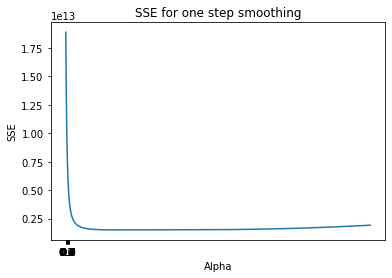

In [80]:
plt.figure()
plt.plot(sse_one)
plt.title("SSE for one step smoothing")
plt.ylabel("SSE")
plt.xlabel("Alpha")
plt.xticks(np.linspace(0, 100, 10), ["{0:1.1f}".format(x) for x in np.linspace(0,1,10)])
plt.show()

Find the best fitting alpha based on the minimum SSE. Here you can use `np.argmin()` function

In [82]:
%%time
optimal_alpha_one = alphas[np.argmin(sse_one)]
print("Optimal Alpha for 1-step forecast {:.2f}".format(optimal_alpha_one))

Optimal Alpha for 1-step forecast 0.18
CPU times: user 947 µs, sys: 115 µs, total: 1.06 ms
Wall time: 1.02 ms


**Note:** In this implementation, since we are interested in smoothing the time series using SES, we obtain $\alpha$ as the value that minimizes the **in-sample** series. If we want to use SES as a forecasting technique, it is more relevant to find the $\alpha$ that minimize **out-of-sample** forecast (then we need to do in-sample/out-of-sample split).    

## 3. Implement  the trend corrected exponential smoothing (TCES) method

In this section, we will implement the trend method for smoothing, more specifically, TCES or Holt's linear method. In the simple exponential smoothing task, we set level $l_t$ as the forecast result, which is:

$$
\widehat{Y}_{t+h|1:t} = l_t
\tag{6}
$$

Compared to the SES method, the TCES method estimates $\widehat{Y}_{t+h|1:t}$ by combining the level and trend, and hence it introduces additional equation to model the trend separately. In general, the forecast equation in Holtss linear method is defined as:

$$
\widehat{Y}_{t+h|1:t} = l_t + h b_t
\tag{7}
$$ 

where the level $l_t$ is:

$$
l_t = \alpha Y_t + (1-\alpha) (l_{t-1}+b_{t-1})
\tag{8}
$$

end the trend is:

$$
b_t = \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1}
\tag{9}
$$

For one-step forecast, we have $h=1$, and

$$ 
\begin{eqnarray}
\widehat{Y}_{t+1|1:t} &=& l_t + b_t \\
&=&  \alpha Y_t + (1-\alpha) (l_{t-1}+b_{t-1}) + \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1}
\end{eqnarray}
\tag{10}
$$

with $0 \le \alpha \le 1$ and $ 0 \le \beta \le 1$.

Similar to the SES algorithm, the TCES method can be used to smooth or forecast time series data. For h-step forecasting, we will use $l_t + h \times b_t$ as the forecast value of $Y_{t+h}$, e.g. $\widehat{Y}_{t+h|1:t} = l_t + h \times b_t$. The following code shows how to implement the TCES to make one-step-ahead forecasts for the number of visitors in the 12 months of 2016, which is the out-of-sample period.

**Note:** In the following implementation, we assume that the values for $\alpha$ and $\beta$ have been already optimized, e.g. performing grid search for $\alpha$ and $\beta$ using in-sample data. For the initial level and initial trend, we initialize $l_0 = y_1$, $b_0=y_2-y_1$.

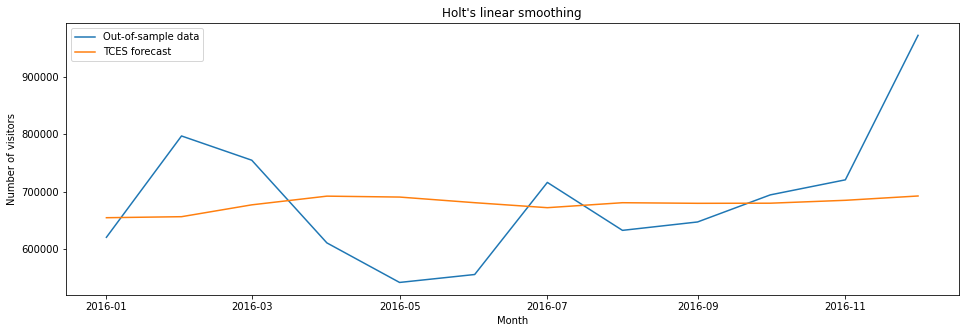

In [83]:
# Extract data for in-sample period (1991-2015)
# We use this portion of data to search for optimal value 
# of alpha and beta (which is assumed to be done here)
visitors_in = visitors['1991':'2015']
T_in = len(visitors_in) 

# Extract data for out-of-sample period (2016)
# We will compare the forecast values to these observations
visitors_out = visitors['2016']
T_out = len(visitors_out)

# Set a small value for alpha and beta
alpha = 0.1           
beta = 0.1
# predict new value from alpha and beta
# Assign initial values for level and trend 
l0 = visitors[0]
b0 = visitors[1] - visitors[0]

# Initialize the smoothed, level and trend series by copying the visitors series(pre-allocation)
# By doing this, we imply that l0 is set to be the first value of the visitors series
y_forecast = visitors.copy().astype(float) 
lt = visitors.copy().astype(float)
bt = visitors.copy().astype(float)

# Compute l[1], b[1] and Y_hat[2]
lt[0] = alpha * visitors[0] + (1 - alpha) * (l0 + b0)
bt[0] = beta * (lt[0] - l0) + (1 - beta) * b0
y_forecast[1] = lt[0] + bt[0]

# Create a loop to compute the forecast values using TCES
for t in range(1,len(visitors)-1):
    
    # Compute level component
    lt[t] = alpha * visitors[t] + (1 - alpha) * (lt[t-1] + bt[t-1])
    
    # Compute trend component
    bt[t] = beta * (lt[t] - lt[t-1]) + (1 - beta) * bt[t-1]
    
    # Get the one-step-ahead forecast values
    y_forecast[t+1] = lt[t] + bt[t]
    
# Extract one-step-ahead forecast values for out-of-sample data
y_forecast_out = y_forecast[-T_out:]

# Ploting the smoothing and forecast results
plt.figure(figsize=(16,5))
plt.plot(visitors_out, label="Out-of-sample data")
plt.plot(y_forecast_out, label="TCES forecast")
plt.xlabel('Month')
plt.ylabel('Number of visitors')
plt.title("Holt's linear smoothing")
plt.legend()




plt.show()

The out-of-sample forecast values do not quite track well the true data. This is expected as the $\alpha$ and $\beta$ are not carefully selected. You could change another value of $\alpha$ and $\beta$ (i.e. 0.9), and then compare your new results with this one.

**Note**: `Pandas` does not have a functionality of Holt's linear trend exponential smoothing but there is a full set of functionalities of all the Holtwinters smoothing in the `statsmodels` package.

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation</h3></div>

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html (`statsmodels` Holtwinters library)


# Tasks

1. Repeat the process of selecting $\alpha$ in section 2.3 but using 2-step smoothing

2. In section 2, we have learnt how to select the best fitted $\alpha$ value for one-step forecasting. Now, continue with the Section 2 of week 06 tutorial, you need to find the best fitted $\alpha$ and $\beta$ value for the **AustralianVisitors.csv** dataset:
 - Load the dataset and implement a Holt's linear trend smoothing.
 - Define a range of $\alpha$ and $\beta$ value to iterate over to calculate the SSE for out-of-sample forecasts.
 - Report the best fitted $\alpha$ and $\beta$ value and summarize your observation
